# CheXchoNet Dataset Exploration

This notebook is meant to get you started with the released chest X-ray dataset and accompanying structural heart disease labels extracted via echocardiography.
It contains a basic demonstration of what is in the data and summary statistics of the features/labels. 

## Clinical Motivation

### Background

Early detection of structural changes in the heart is crucial for improving outcomes in heart failure patients, but initial signs can be nonspecific, leading to delays in diagnosis. Millions of individuals with left ventricular (LV) abnormalities remain undiagnosed, which worsens prognosis. Detecting heart failure earlier, ideally before symptoms manifest, is a key goal in cardiology. 

While echocardiography is the primary diagnostic tool for LV abnormalities, it's often conducted on a limited patient population with high pre-test probability. In contrast, chest X-rays (CXRs) are cheaper and more widely performed but haven't been extensively used for cardiac pathology detection. Thus, CXRs could serve as a valuable data source to develop scalable screening tools using machine learning methods. **This dataset pairs each chest X-ray with corresponding gold standard information from echocardiograms conducted on the same patient, enabling more specific clinically actionable detection tasks.**

### Labels

We focus on detecting two labels which are typically diagnosed via echocardiography using just chest X-rays:

1. Severe Left Ventricular Hypertrophy (SLVH): A thickening of the walls of the left ventricle.  
2. Dilated Left Ventricle (DLV): An overall increase in the size of the left heart chamber.

| <img src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2013/08/26/11/03/ds00680-ans7_lvhthu_jpg.jpg" alt="drawing" width="500"/> | <img src="https://assets.mayoclinic.org/content/dam/media/en/images/2023/02/09/dilated-cardiomyopathy.jpg" alt="drawing" width="500"/> | 
|:--:|:--:| 
| Severe Left Ventricular Hypertrophy | Dilated Left Ventricle |

<ins>Images courtesy of the Mayo Clinic</ins>
* Left Ventricular Hypertrophy: https://www.mayoclinic.org/diseases-conditions/left-ventricular-hypertrophy/symptoms-causes/syc-20374314
* Dilated Left Ventricle: https://www.mayoclinic.org/diseases-conditions/dilated-cardiomyopathy/symptoms-causes/syc-20353149

## Metadata

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('seaborn')

In [2]:
root_path_to_data = "" # replace this with root path
metadata_file = os.path.join(root_path_to_data, "metadata.csv") # point this to metadata file
metadata = pd.read_csv(metadata_file)

In [3]:
metadata.columns

Index(['patient_id', 'cxr_filename', 'cxr_time_offset', 'cxr_year', 'cxr_path',
       'cxr_pixel_spacing_x', 'cxr_pixel_spacing_y', 'age', 'sex', 'ivsd',
       'lvpwd', 'lvidd', 'slvh', 'dlv', 'composite_slvh_dlv',
       'heart_transplant', 'lung_transplant', 'pacemaker_or_icd'],
      dtype='object')

#### Data Dictionary

<ins>Patient Information</ins>

* `patient_id`: unique patient identifier (hashed 32 character hexadecimal number)

<ins>Chest X-ray Information</ins>
 
* `cxr_filename`: combination of patient identifier and 8 digit hexadecimal number which specifies file (there can be more than one chest X-ray for a given patient)
* `cxr_time_offset`: time in days to be used for assessing temporal differences between chest X-rays conducted on the same patient (e.g., for sequential analyses)
* `cxr_year`: the original year in which the cxr was conducted
* `cxr_path`: the relative path to the cxr (all jpg files are under directory `./cxrs/`)
* `cxr_pixel_spacing_x`: the physical distance between two adjacent pixels in a row (in millimeters)
* `cxr_pixel_spacing_y`: the physical distance between two adjacent pixels in a column (in millimeters)

<ins>Demographic Information</ins>

* `age`: the age of the patient rounded to the nearest whole number and truncated to be below 90 (for de-identification)
* `sex`: patient sex ('M' or 'F') 

<ins>Echocardiography Labels</ins>

* `ivsd`: interventricular septal thickness at end diastole, continous label which measures the septal wall thickness (the wall of tissue that separates the heart's right and left sides)
* `lvpwd`: left ventricular posterior wall distance at end diastole, continuous label which measures the thickness of the left walls of the heart in centimeters
* `lvidd`: left ventricular internal diameter at end diastole, continuous label which measures the overall size of the left ventricle in centimeters
* `slvh`: binary label indicating the presence of severe left ventricular hypertrophy, computed by thresholding `ivsd` and `lvpwd`
* `dlv`: binary label indicated the presence of dilated left ventricle, computed by thresholding `lvidd`
* `composite_slvh_dlv`: the presence of either `slvh` or `dlv`

<ins>Misc Labels</ins>

* `heart_transplant`: binary label indicating that the patient has had a heart transplant prior to this chest x-ray
* `lung_transplant`: binary label indicating that the patient has had a lung transplant prior to this chest x-ray
* `pacemaker_or_icd`: binary label indicating that the patient has had a pacemaker of implantable cardioverter-defibrillator inserted

## Summary Statistics and Data Visualization

#### Overall Statistics

In [4]:
print("Total number of chest X-rays", metadata['cxr_filename'].nunique())
print("Total number of patients", metadata['patient_id'].nunique())

Total number of chest X-rays 71589
Total number of patients 24689


#### Distributions of Continuous and Binary Features/Labels

Text(0.5, 1.0, 'Age distribution')

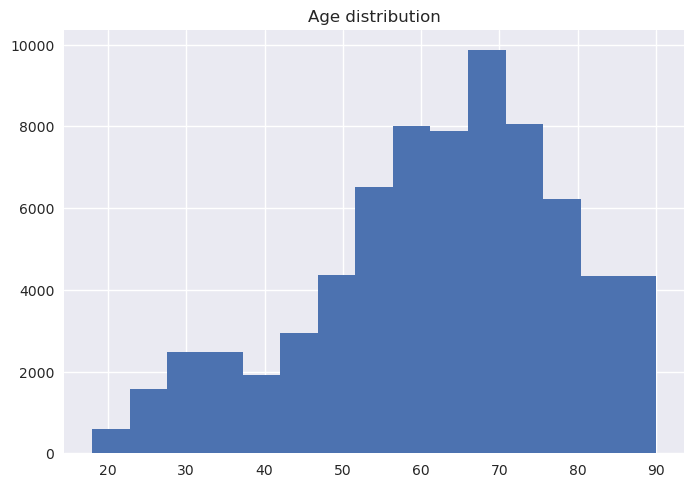

In [5]:
# Age distribution
metadata['age'].hist(bins=15)
plt.title("Age distribution")

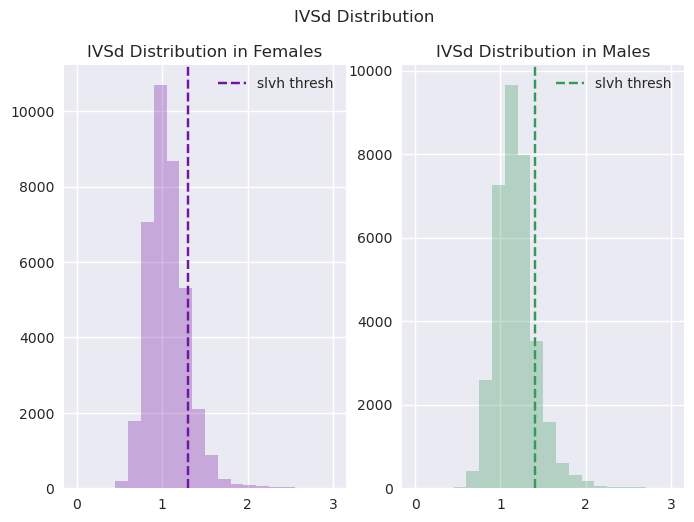

In [6]:
fig, axs = plt.subplots(1,2)

metadata[metadata['sex'] == 'F']['ivsd'].hist(bins=20, range=[0,3], alpha=0.3, color='#7314a3', ax=axs[0])
axs[0].axvline(x=1.3, label='slvh thresh', linestyle='--', c='#7314a3')
axs[0].set_title('IVSd Distribution in Females')

metadata[metadata['sex'] == 'M']['ivsd'].hist(bins=20, range=[0,3], alpha=0.3, color='#359a59', ax=axs[1])
axs[1].axvline(x=1.4, label='slvh thresh', linestyle='--', c='#359a59')
axs[1].set_title('IVSd Distribution in Males')


plt.suptitle("IVSd Distribution")
axs[0].legend()
axs[1].legend()

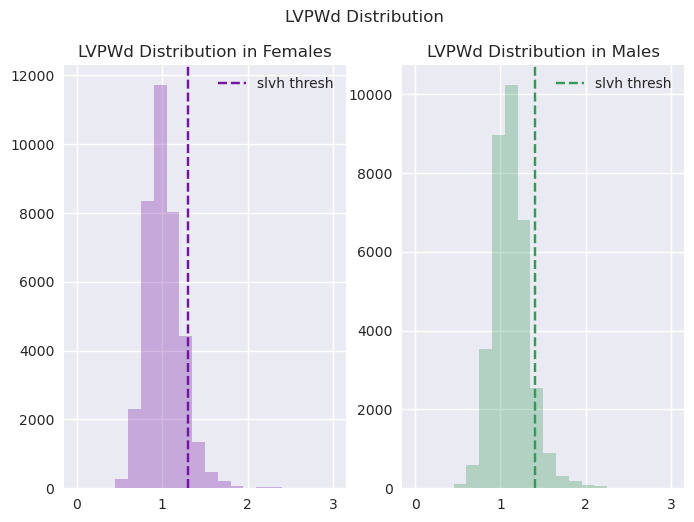

In [7]:
fig, axs = plt.subplots(1,2)

metadata[metadata['sex'] == 'F']['lvpwd'].hist(bins=20, range=[0,3], alpha=0.3, color='#7314a3', ax=axs[0])
axs[0].axvline(x=1.3, label='slvh thresh', linestyle='--', c='#7314a3')
axs[0].set_title('LVPWd Distribution in Females')

metadata[metadata['sex'] == 'M']['lvpwd'].hist(bins=20, range=[0,3], alpha=0.3, color='#359a59', ax=axs[1])
axs[1].axvline(x=1.4, label='slvh thresh', linestyle='--', c='#359a59')
axs[1].set_title('LVPWd Distribution in Males')


plt.suptitle("LVPWd Distribution")
axs[0].legend()
axs[1].legend()

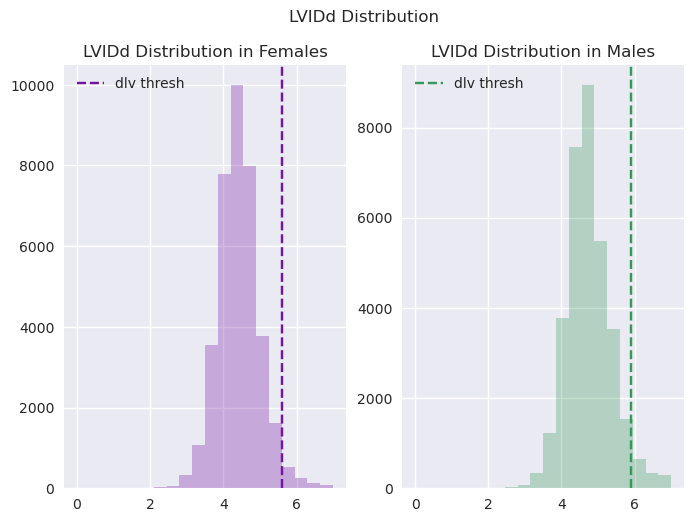

In [8]:
fig, axs = plt.subplots(1,2)

metadata[metadata['sex'] == 'F']['lvidd'].hist(bins=20, range=[0,7], alpha=0.3, color='#7314a3', ax=axs[0])
axs[0].axvline(x=5.6, label='dlv thresh', linestyle='--', c='#7314a3')
axs[0].set_title('LVIDd Distribution in Females')

metadata[metadata['sex'] == 'M']['lvidd'].hist(bins=20, range=[0,7], alpha=0.3, color='#359a59', ax=axs[1])
axs[1].axvline(x=5.9, label='dlv thresh', linestyle='--', c='#359a59')
axs[1].set_title('LVIDd Distribution in Males')


plt.suptitle("LVIDd Distribution")
axs[0].legend()
axs[1].legend()

In [9]:
metadata[['ivsd', 'lvpwd','lvidd']].describe()

,ivsd,lvpwd,lvidd
count,71589.000000,71589.000000,71589.000000
mean,1.120504,1.069995,4.607895
std,0.265316,0.224287,0.679750
min,0.025031,0.000000,0.000000
25%,0.955074,0.920626,4.192120
50%,1.095750,1.049800,4.549390
75%,1.246160,1.195820,4.926620
max,9.881210,6.404550,9.721510


In [10]:
metadata[['slvh','dlv','composite_slvh_dlv']].sum(axis=0)

slvh                  6191
dlv                   4343
composite_slvh_dlv    9861
dtype: int64

In [11]:
metadata[['slvh','dlv','composite_slvh_dlv']].sum(axis=0) / len(metadata)

slvh                  0.086480
dlv                   0.060666
composite_slvh_dlv    0.137745
dtype: float64

In [12]:
metadata[['heart_transplant','lung_transplant','pacemaker_or_icd']].sum(axis=0)

heart_transplant    7126
lung_transplant     9176
pacemaker_or_icd    5069
dtype: int64

In [13]:
metadata[['heart_transplant','lung_transplant','pacemaker_or_icd']].sum(axis=0) / len(metadata)

heart_transplant    0.099540
lung_transplant     0.128176
pacemaker_or_icd    0.070807
dtype: float64

#### Explore CXR Time Differences

In [14]:
metadata['cxr_time_offset'] = metadata['cxr_time_offset'].map(lambda x: pd.Timedelta(x))

In [15]:
metadata_sorted = metadata.sort_values(['patient_id', 'cxr_time_offset'])

In [16]:
def dat_diff(x):
    if len(x) == 1:
        return pd.Series([np.nan])
    else:
        diff_months = (x.iloc[1:].to_numpy() - x.iloc[:-1].to_numpy())

        diff_successive = np.concatenate(
            (np.array([np.nan]), diff_months)
        )
        return pd.Series(diff_successive)

In [17]:
metadata_sorted['cxr_time_offset_days'] = metadata_sorted['cxr_time_offset'].map(lambda x: x / np.timedelta64(1, 'D'))

In [18]:
metadata_sorted['cxr_diff_days'] = metadata_sorted[['patient_id','cxr_time_offset_days']].groupby('patient_id').transform(dat_diff)['cxr_time_offset_days']

Text(0.5, 1.0, 'Number of days between successive chest X-rays')

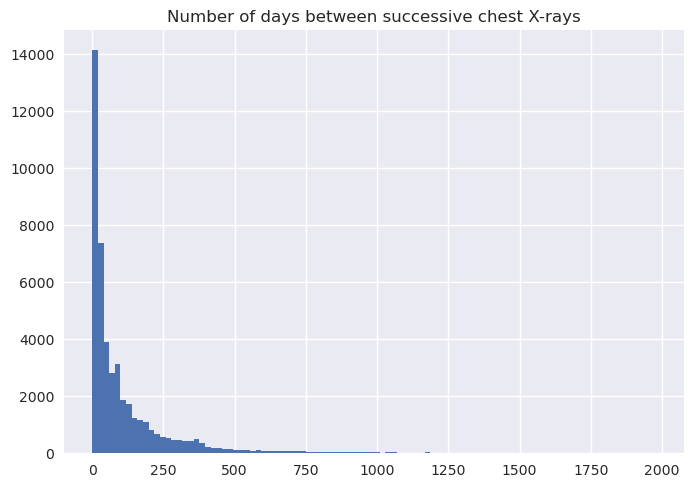

In [19]:
metadata_sorted[~(metadata_sorted['cxr_diff_days'].isna())]['cxr_diff_days'].hist(bins=100)
plt.title("Number of days between successive chest X-rays")

#### Visualize CXR Images

In [ ]:
# View sample of chest X-rays in the data
chunk = metadata.iloc[:9]

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  
                nrows_ncols=(3, 3),  
                axes_pad=0.5,  # pad between axes in inch.
                )

for ax, (im_idx, im) in zip(grid, list(zip(chunk['cxr_filename'], chunk['cxr_path']))):
    
    im = os.path.join(root_path_to_data, im)
    # Iterating over the grid returns the Axes.    
    im = cv2.imread(im)
    ax.imshow(im)
    ax.axis('off')
    ax.text(0.5, -0.1, f"{im_idx}", fontsize=6, ha='center', transform=ax.transAxes)

## Questions?

Please email or message us with questions:

**Author:** Shreyas Bhave 

**Email:** sab2323@cumc.columbia.edu

**Twitter:** @sabhave